# Investigating the Yahoo R2 Data

## Set Up

In [2]:
# Import modules
import pickle
import unittest
import numpy as np
import pandas as pd
from unittest import TestCase
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, tmean
from pandas.api.types import CategoricalDtype
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.model_selection import train_test_split

# Define globals & settings
FONT_SIZE = 18
DIMENSIONS = (10, 6)
plt.rcParams.update({'font.size': FONT_SIZE})

## Models

In [2]:
class SVDModel:
    def __init__(self, n_components):
        self.k = n_components
        self.SVD = TruncatedSVD(n_components=self.k)
    
    def fit(self, X):
        self.SVD.fit(X)
    
    def predict(self, user_ratings):
        reduced_user_ratings = self.SVD.transform(user_ratings)
        recast = self.SVD.inverse_transform(reduced_user_ratings)
        return csr_matrix(recast)

In [25]:
class AverageRatingModel:
    def __init__(self, incl_zeros=False):
        self.incl_zeros = incl_zeros
    
    def _tile(self, vec, n, dtype):
        return csr_matrix(np.ones([n,1],dtype=dtype) *\
            csr_matrix(self.avg, dtype=dtype))
    
    def fit(self, training_ratings):
        self.X = training_ratings
        
        self.avg = self.X.sum(axis=0)
        if self.incl_zeros:
            self.avg = self.avg / self.X.shape[0]
        else:
            col_optimized = csc_matrix(self.X)
            denom = (col_optimized > 0).sum(axis=0)
            denom[denom == 0] = 1
            self.avg = self.avg / denom
        self.avg = np.asarray(self.avg)
    
    def predict(self, user_ratings, dtype=np.float32, condense=False):   
        if condense:
            return csr_matrix(self.avg, dtype=dtype)
        else:
            return self._tile(self.avg, user_ratings.shape[0], dtype)

## Loading the Data

In [46]:
train_file = '../ydata-ymusic-user-song-ratings-meta-v1_0/train_0.txt'
test_file = '../ydata-ymusic-user-song-ratings-meta-v1_0/test_0.txt'

In [47]:
train_df = pd.read_csv(train_file, delimiter='\t', names=["user_id", "song_id", "rating"])
train_df.head()

user_id  song_id  rating
0        0      166       5
1        0     2245       4
2        0     3637       4
3        0     5580       4
4        0     5859       4

In [48]:
test_df = pd.read_csv(test_file, delimiter='\t', names=["user_id", "song_id", "rating"])
test_df.head()

user_id  song_id  rating
0        0     7171       5
1        0     8637       4
2        0    21966       4
3        0    35821       5
4        0    82446       5

Check that ids are all sequential (0..N), with none missing. If true, we don't need to do index compression

User ids

In [50]:
np.all(train_df.user_id.unique() == np.arange(train_df.user_id.unique().shape[0]))

True

Song ids

In [51]:
np.all(train_df.song_id.unique() == np.arange(train_df.song_id.unique().shape[0]))

False

Compress song id

In [52]:
def compress_column(train_df, test_df, col):
    # NOTE: may need to return this if we want to do stuff with genre_hierarchy
    compressed_ids = {_id: idx
                      for idx, _id
                      in enumerate(pd.concat([train_df[col],
                                              test_df[col]]).unique())}

    train_df[col] = train_df[col].map(compressed_ids)
    test_df[col] = test_df[col].map(compressed_ids)
    
    return train_df, test_df

train_df, test_df = compress_column(train_df, test_df, "song_id")

## Explore

In [58]:
df = pd.concat((train_df, test_df))

user_id  song_id  rating
0        0        0       5
1        0        1       4
2        0        2       4
3        0        3       4
4        0        4       4

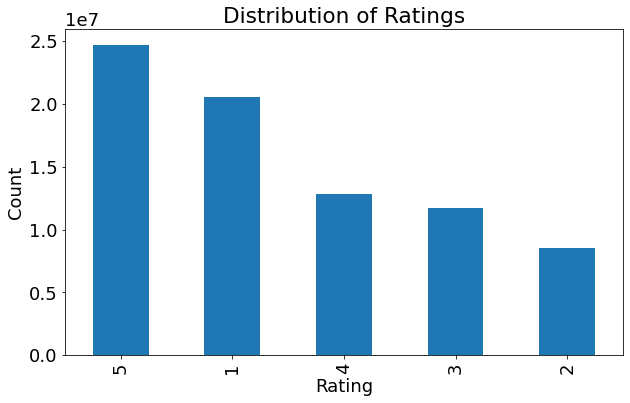

In [61]:
df.rating.value_counts().plot.bar(title='Distribution of Ratings',
                                  xlabel='Rating',
                                  ylabel='Count')
plt.gcf().set_size_inches(DIMENSIONS)

## Set up Train / Test Data

In [53]:
def matricize(df, x_col, y_col, z_col, col_size, sparse_mat=csr_matrix):
    """
    Condense a dataframe into a sparse matrix where x_col becomes
    the rows, y_col becomes the columns, and z_col is the cell content
    """
    x = CategoricalDtype(sorted(df[x_col].unique()), ordered=True)
    y = CategoricalDtype(sorted(df[y_col].unique()), ordered=True)
    
    row = df[x_col].astype(x).cat.codes
    col = df[y_col].astype(y).cat.codes
    
    mat = sparse_mat((df[z_col], (row,col)),
                     shape=(x.categories.size,
                            col_size))
    
    return mat

In [54]:
col_size = max(train_df.song_id.max(), test_df.song_id.max())+1
col_size

136736

In [55]:
X_train = matricize(train_df, "user_id", "song_id", "rating", col_size=col_size)
X_train

<200000x136736 sparse matrix of type '<class 'numpy.int64'>'
	with 76344627 stored elements in Compressed Sparse Row format>

In [56]:
X_test = matricize(test_df, "user_id", "song_id", "rating", col_size=col_size)
X_test

<200000x136736 sparse matrix of type '<class 'numpy.int64'>'
	with 2000000 stored elements in Compressed Sparse Row format>

## Evaluate

In [20]:
def rmse(predicted, true):
    return np.sqrt(np.mean((np.array(predicted)-np.array(true))**2))

def pcc(predicted, true):
    r, _ = pearsonr(predicted, true)
    return r

def frac_predicted_nz(predicted, true):
    y = np.array(predicted)
    return np.count_nonzero(y)/y.shape[0]

def evaluate_model(model, X_test, batch_size=1024):
    predicted, true = [], []
    for i in tqdm(range(0,round(X_test.shape[0]/batch_size))):
        batch = X_test[i*batch_size:(i*batch_size)+batch_size]
        pred = model.predict(batch)
        mask = batch > 0

        predicted += list(np.asarray(pred[mask]).ravel())
        true += list(np.asarray(batch[mask]).ravel())
    err = rmse(predicted, true)
    r2 = pcc(predicted, true)
    frac_nz = frac_predicted_nz(predicted, true)
    
    return err, r2, frac_nz

In [22]:
svd_results = {
    "k": [],
    "RMSE": [],
    "R^2": [],
    "Fraction Nonzero": []
}

ks = tqdm([1, 5, 10, 25, 50, 100])
ks.set_description("Sweeping k")

for k in ks:
    model = SVDModel(k)
    model.fit(X_train)
    
    err, r2, frac_nz = evaluate_model(model, X_test)
    svd_results["k"].append(k)
    svd_results["RMSE"].append(err)
    svd_results["R^2"].append(r2)
    svd_results["Fraction Nonzero"].append(frac_nz)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

In [26]:
avg_results = {
    "Zeros Included": [],
    "RMSE": [],
    "R^2": [],
    "Fraction Nonzero": []
}

params = [True, False]

for incl_zeros in params:
    model = AverageRatingModel(incl_zeros=incl_zeros)
    model.fit(X_train)
    
    err, r2, frac_nz = evaluate_model(model, X_test)
    avg_results["Zeros Included"].append(incl_zeros)
    avg_results["RMSE"].append(err)
    avg_results["R^2"].append(r2)
    avg_results["Fraction Nonzero"].append(frac_nz)

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

Save results

In [27]:
# import pickle
# with open('svd_results.pickle', 'wb') as datafile:
#     pickle.dump(svd_results, datafile)
    
# with open('avg_results.pickle', 'wb') as datafile:
#     pickle.dump(avg_results, datafile)

In [3]:
svd_results = {}
avg_results = {}
with open('svd_results.pickle', 'rb') as datafile:
    svd_results = pickle.load(datafile)

with open('avg_results.pickle', 'rb') as datafile:
    avg_results = pickle.load(datafile)

In [5]:
results_df = pd.DataFrame(svd_results)
results_df.groupby(["k"]).head()

k      RMSE       R^2  Fraction Nonzero
0    1  3.791522  0.082456               1.0
1    5  3.790435  0.111358               1.0
2   10  3.789076  0.113618               1.0
3   25  3.786197  0.125512               1.0
4   50  3.782165  0.138272               1.0
5  100  3.773942  0.140267               1.0

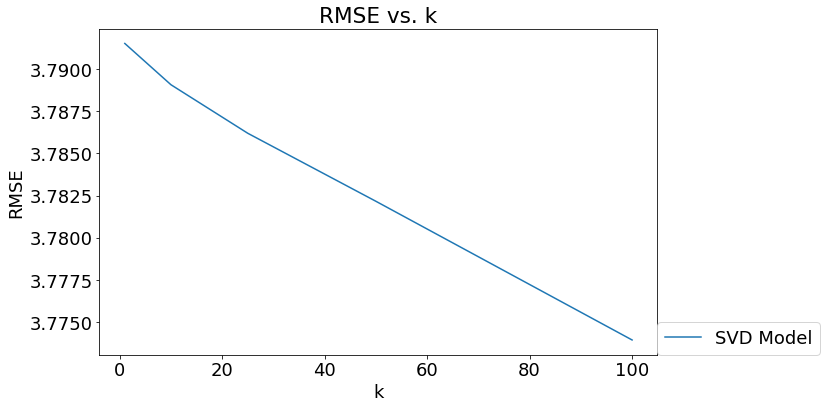

In [45]:
y_axis = "RMSE"
results_df.set_index("k")[y_axis].plot(title=f"{y_axis} vs. k",
                                       xlabel="k",
                                       ylabel=y_axis,
                                       label='SVD Model',
                                       legend=True)

# def color_yielder():
#     while True:
#         for c in ['c','g','r','b','m','y','k']:
#             yield c
# color_generator = color_yielder()

# for idx in range(len(avg_results["Zeros Included"])):
#     incl_zeros = avg_results["Zeros Included"][idx]
#     rmse = avg_results["RMSE"][idx]
#     plt.axhline(rmse, color=next(color_generator),
#                 label=f'Average resultings (include zeros={incl_zeros})')

plt.legend(loc=(1,0))
plt.gcf().set_size_inches(DIMENSIONS)

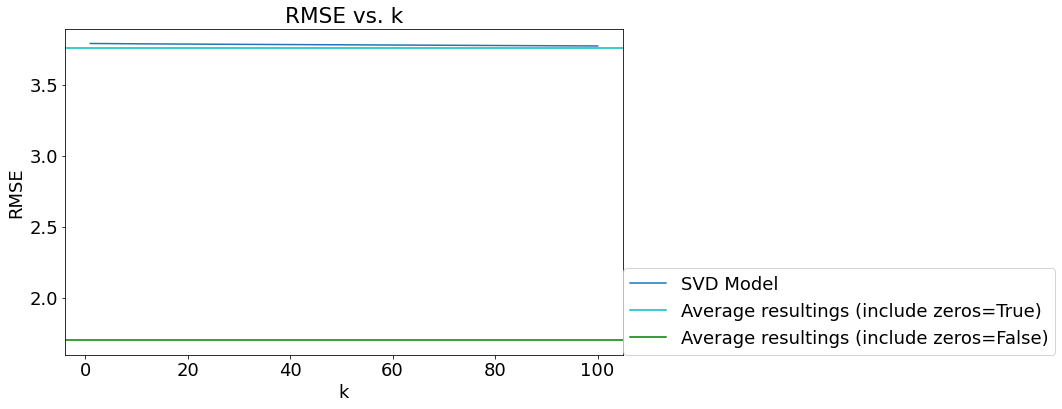

In [42]:
y_axis = "RMSE"
results_df.set_index("k")[y_axis].plot(title=f"{y_axis} vs. k",
                                       xlabel="k",
                                       ylabel=y_axis,
                                       label='SVD Model',
                                       legend=True)

def color_yielder():
    while True:
        for c in ['c','g','r','b','m','y','k']:
            yield c
color_generator = color_yielder()

for idx in range(len(avg_results["Zeros Included"])):
    incl_zeros = avg_results["Zeros Included"][idx]
    rmse = avg_results["RMSE"][idx]
    plt.axhline(rmse, color=next(color_generator),
                label=f'Average resultings (include zeros={incl_zeros})')

plt.legend(loc=(1,0))
plt.gcf().set_size_inches(DIMENSIONS)

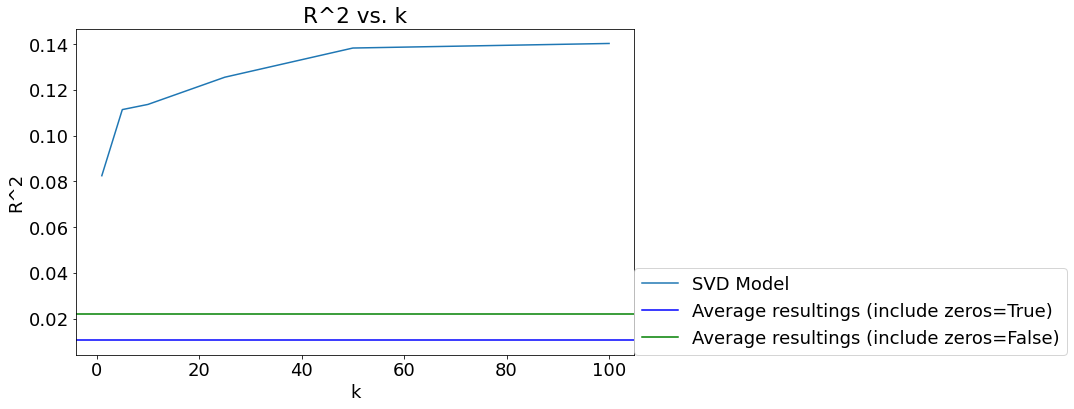

In [65]:
y_axis = "R^2"
results_df.set_index("k")[y_axis].plot(title=f"{y_axis} vs. k",
                                       xlabel="k",
                                       ylabel=y_axis,
                                       label='SVD Model',
                                       legend=True)


def color_yielder():
    while True:
        for c in ['b','g','r','c','m','y','k','w']:
            yield c
color_generator = color_yielder()

for idx in range(len(avg_results["Zeros Included"])):
    incl_zeros = avg_results["Zeros Included"][idx]
    r2 = avg_results["R^2"][idx]
    plt.axhline(r2, color=next(color_generator),
                label=f'Average resultings (include zeros={incl_zeros})')

plt.legend(loc=(1,0))
plt.gcf().set_size_inches(DIMENSIONS)